In [2]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import seaborn as sns
import matplotlib.pyplot as plt

In [33]:
from patsy import dmatrices
from sklearn.linear_model import LogisticRegression 
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_curve

In [4]:
dta =sm.datasets.fair.load_pandas().data
dta.head()

,rate_marriage,age,yrs_married,children,religious,educ,occupation,occupation_husb,affairs
0,3.0,32.0,9.0,3.0,3.0,17.0,2.0,5.0,0.111111
1,3.0,27.0,13.0,3.0,1.0,14.0,3.0,4.0,3.230769
2,4.0,22.0,2.5,0.0,1.0,16.0,3.0,5.0,1.400000
3,4.0,37.0,16.5,4.0,3.0,16.0,5.0,5.0,0.727273
4,5.0,27.0,9.0,1.0,1.0,14.0,3.0,4.0,4.666666


In [5]:
#add "affair" column: 1 represents having affairs, 0represents not 
dta['affair'] = (dta.affairs >0).astype(int)
dta.head()

,rate_marriage,age,yrs_married,children,religious,educ,occupation,occupation_husb,affairs,affair
0,3.0,32.0,9.0,3.0,3.0,17.0,2.0,5.0,0.111111,1
1,3.0,27.0,13.0,3.0,1.0,14.0,3.0,4.0,3.230769,1
2,4.0,22.0,2.5,0.0,1.0,16.0,3.0,5.0,1.400000,1
3,4.0,37.0,16.5,4.0,3.0,16.0,5.0,5.0,0.727273,1
4,5.0,27.0,9.0,1.0,1.0,14.0,3.0,4.0,4.666666,1


### 1) Data Exploration

In [6]:
dta.groupby('affair').mean()

,rate_marriage,age,yrs_married,children,religious,educ,occupation,occupation_husb,affairs
affair,,,,,,,,,
0,4.329701,28.390679,7.989335,1.238813,2.504521,14.322977,3.405286,3.833758,0.000000
1,3.647345,30.537019,11.152460,1.728933,2.261568,13.972236,3.463712,3.884559,2.187243


Obsevation:
    On average, women who have affairs rate their marriages lower
    Also increase in yrs_married correlate with extra marital affairs
       

In [7]:
dta.groupby('rate_marriage').mean()

,age,yrs_married,children,religious,educ,occupation,occupation_husb,affairs,affair
rate_marriage,,,,,,,,,
1.0,33.823232,13.914141,2.308081,2.343434,13.848485,3.232323,3.838384,1.201671,0.747475
2.0,30.471264,10.727011,1.735632,2.330460,13.864943,3.327586,3.764368,1.615745,0.635057
3.0,30.008056,10.239174,1.638469,2.308157,14.001007,3.402820,3.798590,1.371281,0.550856
4.0,28.856601,8.816905,1.369536,2.400981,14.144514,3.420161,3.835861,0.674837,0.322926
5.0,28.574702,8.311662,1.252794,2.506334,14.399776,3.454918,3.892697,0.348174,0.181446


Observation:
     Increase in age, yrs_married, and children appears to correlate with a declining marriage rating.

### 2) Data Visualization

<AxesSubplot:xlabel='educ', ylabel='Count'>

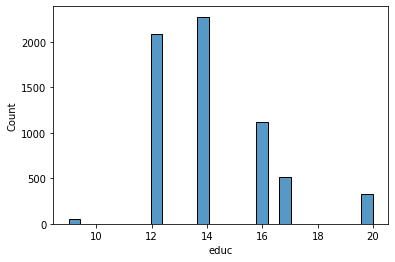

In [8]:
sns.histplot(dta['educ'])

<AxesSubplot:xlabel='occupation', ylabel='Count'>

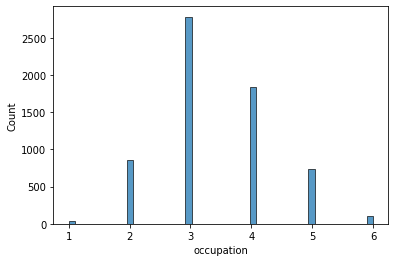

In [9]:
sns.histplot(dta['occupation'])

<AxesSubplot:xlabel='rate_marriage', ylabel='Count'>

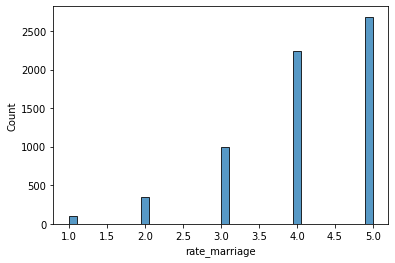

In [10]:
sns.histplot(dta['rate_marriage'])

#### Distribution of marriage ratings for those having affairs versus those not having affairs.

In [11]:
pd.crosstab(dta.rate_marriage,dta.affair.astype(bool))

affair,False,True
rate_marriage,,
1.0,25,74
2.0,127,221
3.0,446,547
4.0,1518,724
5.0,2197,487


<AxesSubplot:xlabel='rate_marriage'>

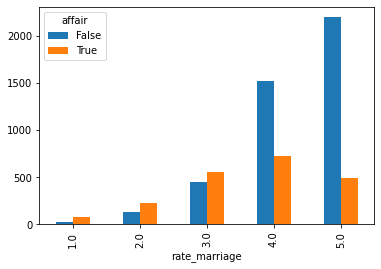

In [12]:
pd.crosstab(dta.rate_marriage,dta.affair.astype(bool)).plot(kind='bar')

#### Percentage of women having affairs by number of years of marriage.

In [13]:
affair_yrs_married=pd.crosstab(dta.yrs_married,dta.affair.astype(bool))
affair_yrs_married

affair,False,True
yrs_married,,
0.5,354,16
2.5,1595,439
6.0,754,387
9.0,348,254
13.0,347,243
16.5,449,369
23.0,466,345


<AxesSubplot:xlabel='yrs_married'>

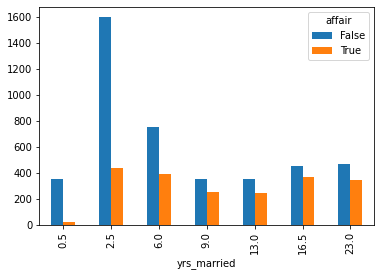

In [14]:
pd.crosstab(dta.yrs_married,dta.affair.astype(bool)).plot(kind='bar')

<AxesSubplot:xlabel='yrs_married'>

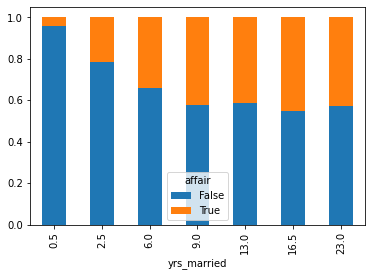

In [15]:
affair_yrs_married.div(affair_yrs_married.sum(1).astype(float),axis=0).plot(kind='bar',stacked=True)

### 3) Logistic Regression

In [16]:
dta['affair'].value_counts()

0    4313
1    2053
Name: affair, dtype: int64

In [17]:
dta['affair'].mean()

0.3224945020420987

In [18]:
y, X = dmatrices('affair ~ rate_marriage + age +yrs_married + children+religious + educ +C(occupation) + C(occupation_husb)',dta, return_type="dataframe")
X

,Intercept,C(occupation)[T.2.0],C(occupation)[T.3.0],C(occupation)[T.4.0],C(occupation)[T.5.0],C(occupation)[T.6.0],C(occupation_husb)[T.2.0],C(occupation_husb)[T.3.0],C(occupation_husb)[T.4.0],C(occupation_husb)[T.5.0],C(occupation_husb)[T.6.0],rate_marriage,age,yrs_married,children,religious,educ
0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,3.0,32.0,9.0,3.0,3.0,17.0
1,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,3.0,27.0,13.0,3.0,1.0,14.0
2,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,4.0,22.0,2.5,0.0,1.0,16.0
3,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,4.0,37.0,16.5,4.0,3.0,16.0
4,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,5.0,27.0,9.0,1.0,1.0,14.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6361,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,5.0,32.0,13.0,2.0,3.0,17.0
6362,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,4.0,32.0,13.0,1.0,1.0,16.0
6363,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,22.0,2.5,0.0,2.0,14.0
6364,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,5.0,32.0,6.0,1.0,3.0,14.0


In [19]:
X=X.rename(columns =
{'C(occupation)[T.2.0]':'occ_2',
'C(occupation)[T.3.0]':'occ_3',
'C(occupation)[T.4.0]':'occ_4',
'C(occupation)[T.5.0]':'occ_5',
'C(occupation)[T.6.0]':'occ_6',
'C(occupation_husb)[T.2.0]':'occ_husb_2',
'C(occupation_husb)[T.3.0]':'occ_husb_3',
'C(occupation_husb)[T.4.0]':'occ_husb_4',
'C(occupation_husb)[T.5.0]':'occ_husb_5',
'C(occupation_husb)[T.6.0]':'occ_husb_6'})

y = np.ravel(y)

In [21]:
X.head(2)

,Intercept,occ_2,occ_3,occ_4,occ_5,occ_6,occ_husb_2,occ_husb_3,occ_husb_4,occ_husb_5,occ_husb_6,rate_marriage,age,yrs_married,children,religious,educ
0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,3.0,32.0,9.0,3.0,3.0,17.0
1,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,3.0,27.0,13.0,3.0,1.0,14.0


In [22]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.30, random_state=101)
logmodel = LogisticRegression()
logmodel.fit(X_train,y_train)


C:\Users\hanesha\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [24]:
## Checking accuracy of the model with training data
pred=logmodel.predict(X_train)
accuracy=accuracy_score(y_train,pred)
print("Training data accuracy:",accuracy)

Training data accuracy: 0.730475763016158


In [25]:
## Checking accuracy of the model with testing data
predictions = logmodel.predict(X_test)
from sklearn.metrics import accuracy_score
accuracy=accuracy_score(y_test,predictions)
print("Testing data accuracy:",accuracy)

Testing data accuracy: 0.7115183246073299


In [26]:
print(predictions)

[0. 0. 0. ... 0. 0. 0.]


In [27]:
#Checking the probability of sample belongs to each class(col1-class0,col2-class1)
logmodel.predict_proba(X_test)


array([[0.52077387, 0.47922613],
       [0.58548108, 0.41451892],
       [0.73547215, 0.26452785],
       ...,
       [0.9471707 , 0.0528293 ],
       [0.87008824, 0.12991176],
       [0.87867712, 0.12132288]])

In [30]:
## Let's check the confusion matrix
accuracy=confusion_matrix(y_test,predictions)
accuracy

array([[1158,  119],
       [ 432,  201]], dtype=int64)

In [31]:
print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

         0.0       0.73      0.91      0.81      1277
         1.0       0.63      0.32      0.42       633

   micro avg       0.71      0.71      0.71      1910
   macro avg       0.68      0.61      0.61      1910
weighted avg       0.70      0.71      0.68      1910



In [32]:
## Checking the roc_auc_score

In [34]:
roc_auc_score(y_test,logmodel.predict_proba(X_test)[:, 1])

0.7288539119010418

In [35]:
## Cross validation

#Model accuracy with cross validation
from sklearn.model_selection import cross_val_score
score=cross_val_score(logmodel,X,y,cv=5)
score.mean()

C:\Users\hanesha\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\hanesha\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\hanesha\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\hanesha\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\hanesha\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to

0.7249513738732067